In [1]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 29.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successful

In [31]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.14.0
    Uninstalling tensorflow-addons-0.14.0:
      Successfully uninstalled tensorflow-addons-0.14.0
Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.models import Model
import tensorflow.keras.layers as tfl
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa

In [3]:
tf.__version__

'2.10.0'

In [4]:
DATA_DIR = "../input/coffeecherry/coffee-vs-cherry-plants/"
os.listdir(DATA_DIR)

['Cherry', 'Coffee-plant']

In [5]:
TRAIN_DATA_EL = DATA_DIR

In [18]:
num_classes = 2
input_shape = (256, 256, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
BATCH_SIZE = 64
IMG_SIZE = (256, 256)
directory = TRAIN_DATA_EL
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 61 files belonging to 2 classes.
Using 49 files for training.
Found 61 files belonging to 2 classes.
Using 12 files for validation.


2022-09-28 16:17:52.671269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-09-28 16:17:52.671314: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-28 16:17:52.671349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ca0191e99fa7): /proc/driver/nvidia/version does not exist
2022-09-28 16:17:52.672006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

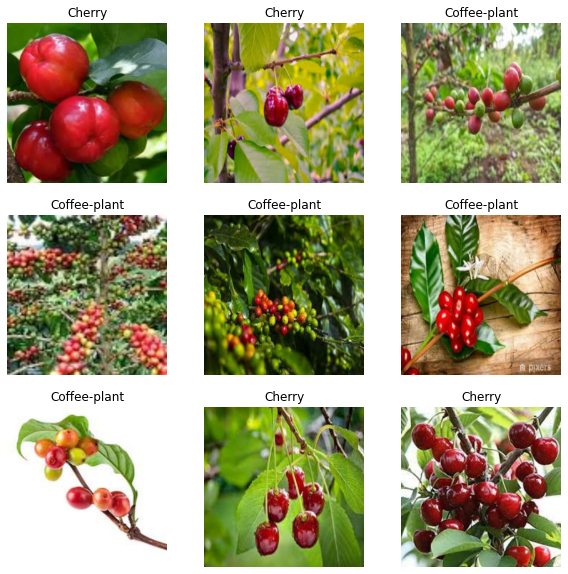

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [21]:
data_augmentation = tf.keras.Sequential(
    [
        tfl.Normalization(),
        tfl.Resizing(image_size, image_size),
        tfl.RandomFlip("horizontal"),
        tfl.RandomRotation(factor=0.02),
        tfl.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
for img, label in train_dataset.take(1):
    data_augmentation.layers[0].adapt(img)

In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [23]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


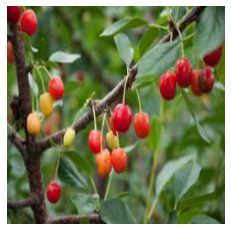

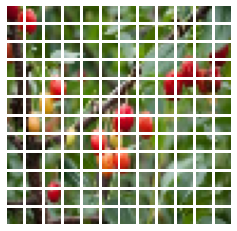

In [25]:
plt.figure(figsize=(4, 4))
image = None
for img, label in train_dataset.take(1):
    image = img[np.random.choice(range(img.shape[0]))]
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [26]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [27]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [34]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=train_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
#     _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 24s 24s/step - loss: 2.0340 - accuracy: 0.4694 - val_loss: 5.8451 - val_accuracy: 0.4167
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 7.2749 - accuracy: 0.4898 - val_loss: 3.9789 - val_accuracy: 0.5833
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 5.0612 - accuracy: 0.5102 - val_loss: 0.6633 - val_accuracy: 0.8333
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 1.5320 - accuracy: 0.6939 - val_loss: 2.1419 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 1.3026 - accuracy: 0.7143 - val_loss: 1.3838 - val_accuracy: 0.7500
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.7332 - accuracy: 0.7347 - val_loss: 1.4225 - val_accuracy: 0.7500
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.5294 - accuracy: 0.7959 - val_loss: 1.4822 - val_accuracy: 0.6667
Epoch 8/100
1/1 [===============

NameError: name 'x_test' is not defined

In [ ]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# def coffee_cherry(image_shape=IMG_SIZE):
#     ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
#     Arguments:
#         image_shape -- Image width and height
#         data_augmentation -- data augmentation function
#     Returns:
#     Returns:
#         tf.keras.model
#     '''
# #     model = tf.keras.Sequential([
# #       tfl.Rescaling(1./255, input_shape=(160, 160, 3)),
# #       tfl.Conv2D(16, 3, padding='same', activation='relu'),
# #       tfl.MaxPooling2D(),
# #       tfl.Conv2D(32, 3, padding='same', activation='relu'),
# #       tfl.MaxPooling2D(),
# #       tfl.Conv2D(64, 3, padding='same', activation='relu'),
# #       tfl.MaxPooling2D(),
# #       tfl.Flatten(),
# #       tfl.Dense(128, activation='relu'),
# #       tfl.Dense(1)
# # ])
# #     return model
#     inp = tfl.Input((256, 256, 3))
#     mobile = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_tensor=inp, input_shape=(256, 256, 3), classifier_activation=None)
#     mobile.trainable = False
#     x = preprocess_input(inp)
#     x = mobile.output
#     x = tfl.GlobalAveragePooling2D()(x)
#     x = tfl.Dropout(0.2)(x)
#     out = tfl.Dense(1)(x)

#     complete_model = Model(inp, out)
#     return complete_model
    
    
    
# #     input_shape = image_shape + (3)
    
# #     base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
# #     input_shape=input_shape,
# #     include_top=False,
# #     weights='imagenet',
# #     input_tensor=inp,
# #     classifier_activation=None 
# #     )
    
# #     base_model.trainable = False
# #     inputs = tf.Input(input_shape)
    
# #     #print(base_model.summary())
# #     #X = data_augmentation(inputs)
    
# #     X = preprocess_input(inputs)
# #     X = base_model(X, training=False)
# #     X = base_model.output
# #     X = tfl.GlobalAveragePooling2D()(X)
# #     X = tfl.Dropout(0.2)(X)
    
# #     prediction_layer = tfl.Dense(1)
    
# #     outputs = prediction_layer(X) 
# #     model = tf.keras.Model(inputs, outputs)
# #     return model

In [ ]:
#model = coffee_cherry(IMG_SIZE)

In [ ]:
# base_learning_rate = 0.01
# # model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
# #               loss=tf.keras.losses.BinaryCrossentropy(),
# #               metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics='accuracy')

In [ ]:
# initial_epochs = 30
# history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

In [ ]:
# history.history.keys()

In [ ]:
#model.summary()

In [ ]:
# acc = [0.] + history.history['accuracy']
# val_acc = [0.] + history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [40]:
def predict(img_path):
    test_image = img_path
    # Loading the image and converting it to a numpy array for feeding it to the model. Its important to use expand_dims since our original model takes batches of images
    # as input, and here we are feeding a single image to it, so the number of dimensions should match for model input.
    img = tf.keras.utils.load_img(test_image, target_size=(256,256))
    img_arr = tf.keras.utils.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)
    pred = vit_classifier.predict(img_arr)
    score = tf.nn.softmax(pred[0])

    return "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

predict("../input/coffeecherry/coffee-vs-cherry-plants/Coffee-plant/images15.jpg")

1/1 [==============================] - 0s 63ms/step


'This image most likely belongs to Coffee-plant with a 81.25 percent confidence.'

In [ ]:
# # Taking the outputs of first 100 layers from trained model, leaving the first Input layer, in a list
# layer_outputs = [layer.output for layer in model.layers[1:100]]

# # This is image of a Rose flower from our dataset. All of the visualizations in this cell are of this image.
# test_image = "../input/test2/coffee2.jpg"
# # Loading the image and converting it to a numpy array for feeding it to the model. Its important to use expand_dims since our original model takes batches of images
# # as input, and here we are feeding a single image to it, so the number of dimensions should match for model input.
# img = tf.keras.utils.load_img(test_image, target_size=(256, 256))
# img_arr = tf.keras.utils.img_to_array(img)
# img_arr = tf.expand_dims(img_arr, 0) # Create a batch


# # Defining a new model using original model's input and all the 100 layers outputs and then predicting the values for all those 100 layers for our test image.
# activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
# activations = activation_model.predict(img_arr)

# # These are names of layers, the outputs of which we are going to visualize.
# layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
# activ_list = [activations[0], activations[2], activations[10], activations[12], activations[17], activations[19]]

In [ ]:
# fig = plt.figure(figsize=(22, 3))
# for img in range(30):
#     ax = fig.add_subplot(2, 15, img+1)
#     ax = plt.imshow(activations[4][0, :, :, img], cmap='viridis')
#     plt.xticks([])
#     plt.yticks([])
#     fig.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.savefig("output-mobile-net-.jpg")